In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
import nltk
import sys
%matplotlib inline

In [2]:
data_path = "./data/Digital_Music_5.json"
table = pd.read_json(data_path, 'records', lines = True).reset_index(drop = True, inplace = False)
print(table.head())

       reviewerID        asin          reviewerName helpful  \
0  A3EBHHCZO6V2A4  5555991584  Amaranth "music fan"  [3, 3]   
1   AZPWAXJG9OJXV  5555991584             bethtexas  [0, 0]   
2  A38IRL0X2T4DPF  5555991584           bob turnley  [2, 2]   
3  A22IK3I6U76GX0  5555991584                 Calle  [1, 1]   
4  A1AISPOIIHTHXX  5555991584           Cloud "..."  [1, 1]   

                                          reviewText  overall  \
0  It's hard to believe "Memory of Trees" came ou...        5   
1  A clasically-styled and introverted album, Mem...        5   
2  I never thought Enya would reach the sublime h...        5   
3  This is the third review of an irish album I w...        5   
4  Enya, despite being a successful recording art...        4   

                        summary  unixReviewTime   reviewTime  
0       Enya's last great album      1158019200  09 12, 2006  
1      Enya at her most elegant       991526400   06 3, 2001  
2               The best so far      1058

In [3]:
from collections import defaultdict
from textblob import TextBlob
def get_sentiment(table):
    polarity = []
    subjectivity = []
    for idx, row in table.iterrows():
        review = TextBlob(row['reviewText'])
        sentiment = review.sentiment
        polarity.append(sentiment.polarity)
        subjectivity.append(sentiment.subjectivity)
    new_table = table
    new_table.insert(len(table.columns), column='polarity', value=polarity)
    new_table.insert(len(table.columns), column='subjectivity', value=subjectivity)
    return new_table

In [4]:
table = get_sentiment(table)
display(table.head())

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,polarity,subjectivity
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006",0.186515,0.501742
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001",0.251479,0.507298
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5,The best so far,1058140800,"07 14, 2003",0.343074,0.668615
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5,Ireland produces good music.,957312000,"05 3, 2000",0.463788,0.459293
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4,4.5; music to dream to,1200528000,"01 17, 2008",0.342808,0.580449


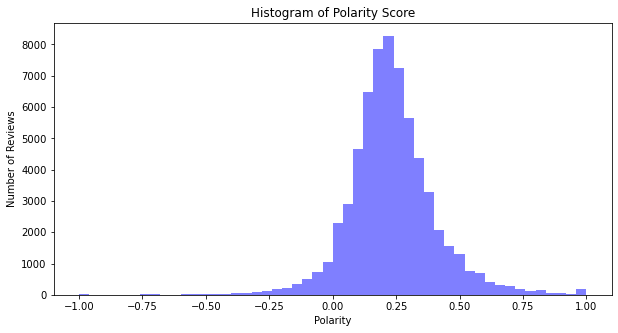

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
num_bins = 50
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(table.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

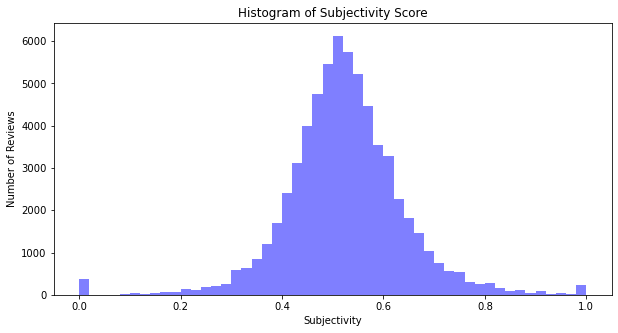

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
num_bins = 50
plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(table.subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Subjectivity Score')
plt.show();

In [7]:
#deal with the bias and noise of the overall column
def unbias(overall, polarity):
    return ((overall+5*polarity)+4)*4/14+1
table['unbias_overall'] = table.apply(lambda row: unbias(row['overall'], row['polarity']), axis=1)
display(table.head())

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,polarity,subjectivity,unbias_overall
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006",0.186515,0.501742,3.837879
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001",0.251479,0.507298,3.930685
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5,The best so far,1058140800,"07 14, 2003",0.343074,0.668615,4.061534
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5,Ireland produces good music.,957312000,"05 3, 2000",0.463788,0.459293,4.233983
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4,4.5; music to dream to,1200528000,"01 17, 2008",0.342808,0.580449,3.775439


In [8]:
table.shape

(64706, 12)

In [9]:
table.describe()['unbias_overall'].T

count    64706.000000
mean         3.681496
std          0.458952
min          1.000000
25%          3.485545
50%          3.769932
75%          3.964286
max          5.000000
Name: unbias_overall, dtype: float64

In [10]:
print('Number of missing values across columns: \n',table.isnull().sum())

Number of missing values across columns: 
 reviewerID          0
asin                0
reviewerName      177
helpful             0
reviewText          0
overall             0
summary             0
unixReviewTime      0
reviewTime          0
polarity            0
subjectivity        0
unbias_overall      0
dtype: int64


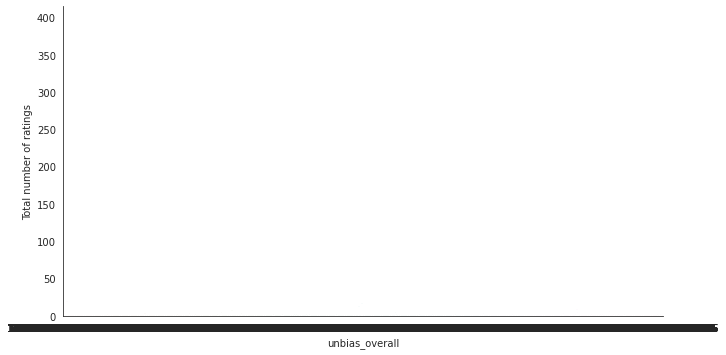

In [11]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("unbias_overall", data=table, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [12]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",table.shape[0])
print("Total No of Users   :", len(np.unique(table.reviewerID)))
print("Total No of products  :", len(np.unique(table.asin)))

Total data 
--------------------------------------------------

Total no of ratings : 64706
Total No of Users   : 5541
Total No of products  : 3568


In [13]:
table.drop(['reviewerName'], axis=1,inplace=True)
table.drop(['helpful'], axis=1,inplace=True)
table.drop(['reviewText'], axis=1,inplace=True)
table.drop(['summary'], axis=1,inplace=True)
table.drop(['unixReviewTime'], axis=1,inplace=True)
table.drop(['reviewTime'], axis=1,inplace=True)
table.drop(['polarity'], axis=1,inplace=True)
table.drop(['overall'], axis=1,inplace=True)
table.drop(['subjectivity'], axis=1,inplace=True)

In [14]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = table.groupby(by='reviewerID')['unbias_overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

reviewerID
A9Q28YTLYREO7     578
A3HU0B9XUEVHIM    375
A3KJ6JAZPH382D    301
A3C6ZCBUNXUT7V    261
A8IFUOL8S9BZC     256
Name: unbias_overall, dtype: int64

In [15]:
no_of_rated_products_per_user.describe()

count    5541.000000
mean       11.677676
std        18.222800
min         5.000000
25%         5.000000
50%         7.000000
75%        11.000000
max       578.000000
Name: unbias_overall, dtype: float64

In [16]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

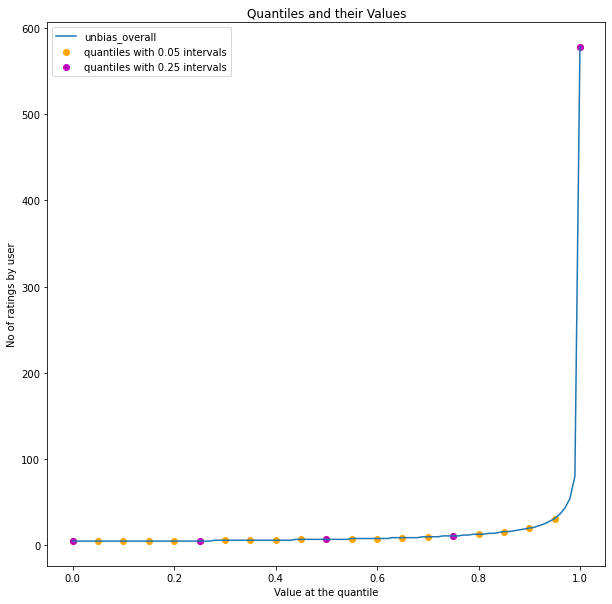

In [17]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [18]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 126



In [19]:
##Popularity Based Recommendation

#Getting the new dataframe which contains users who has given 50 or more ratings
new_df=table.groupby("asin").filter(lambda x:x['unbias_overall'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-50.0, 0, ''),
 Text(0.0, 0, ''),
 Text(50.0, 0, ''),
 Text(100.0, 0, ''),
 Text(150.0, 0, ''),
 Text(200.0, 0, ''),
 Text(250.0, 0, ''),
 Text(300.0, 0, '')]

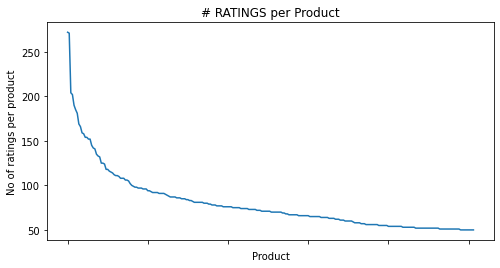

In [20]:
no_of_ratings_per_product = new_df.groupby(by='asin')['unbias_overall'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [21]:
#Average rating of the product 

new_df.groupby('asin')['unbias_overall'].mean().head()

asin
B00000016W    3.837441
B00000064G    3.730589
B000000OUJ    3.886597
B000000TDH    3.799631
B0000013GH    3.861190
Name: unbias_overall, dtype: float64

In [22]:
new_df.groupby('asin')['unbias_overall'].mean().sort_values(ascending=False).head()

asin
B0001XANAS    4.063417
B000002GVS    3.998134
B000002AV5    3.993282
B000001A6N    3.981373
B000003AEK    3.974832
Name: unbias_overall, dtype: float64

In [23]:
#Total no of rating for product

new_df.groupby('asin')['unbias_overall'].count().sort_values(ascending=False).head()

asin
B0007NFL18    272
B000084T18    271
B00006690F    204
B00004T9UF    202
B00005YW4H    190
Name: unbias_overall, dtype: int64

In [24]:
ratings_mean_count = pd.DataFrame(new_df.groupby('asin')['unbias_overall'].mean())

In [25]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['unbias_overall'].count())

In [26]:
ratings_mean_count.head()

,unbias_overall,rating_counts
asin,,
B00000016W,3.837441,135
B00000064G,3.730589,79
B000000OUJ,3.886597,79
B000000TDH,3.799631,54
B0000013GH,3.861190,51


In [27]:
ratings_mean_count['rating_counts'].max()

272

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

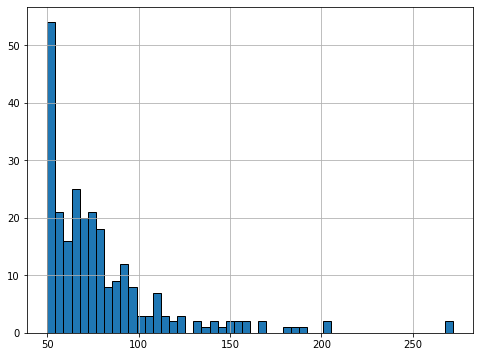

In [28]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

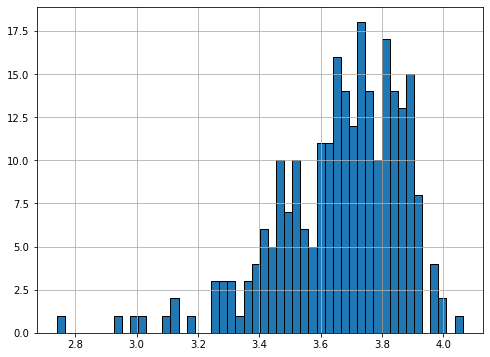

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['unbias_overall'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

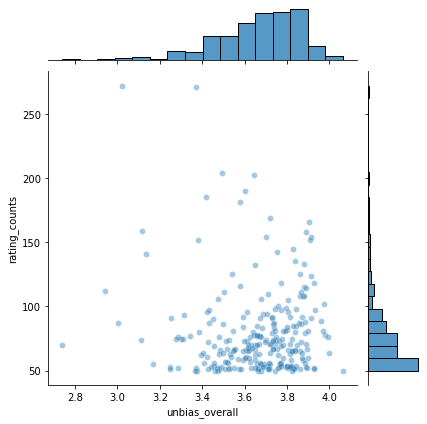

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='unbias_overall', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='asin'>

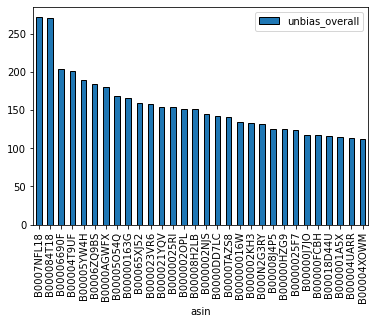

In [31]:
popular_products = pd.DataFrame(new_df.groupby('asin')['unbias_overall'].count())
most_popular = popular_products.sort_values('unbias_overall', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [32]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [33]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
cols = new_df.columns.tolist()
df = new_df[cols] 
# df = df._convert(numeric=True)
print(df)
# print(df.dtypes)
# df['asin']=df['asin'].astype(np.float64)
# print(df.dtypes)

data = Dataset.load_from_df(df,reader)

           reviewerID        asin  unbias_overall
85     A1C0C9IJO2HS03  B00000016W        3.939663
86     A22N9H8V0RYQR3  B00000016W        2.619048
87     A1E110L9ZKX6FD  B00000016W        3.850057
88     A3HU0B9XUEVHIM  B00000016W        3.833282
89     A252HNVAZENVNE  B00000016W        3.358418
...               ...         ...             ...
61354  A2X4WHLXULSKDD  B005QJZ5FA        3.721726
61355   AY6A8KPYCE6B0  B005QJZ5FA        3.712819
61356  A2U3XA8QL4IPJO  B005QJZ5FA        3.836735
61357   AFEN54UGJQOK9  B005QJZ5FA        3.766284
61358  A13Y1WNMYX93EL  B005QJZ5FA        3.689360

[20271 rows x 3 columns]


In [34]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.2,random_state=0)

In [35]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [36]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [37]:
test_pred

[Prediction(uid='AJQMDNJRZP6MD', iid='B00005NHJS', r_ui=4.08843537414966, est=3.540003219189379, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2QMBY3CCR2B02', iid='B0006ZQ9BS', r_ui=3.9109977324263037, est=3.3395984604415863, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A26XCS3QLDJJWN', iid='B000035X1M', r_ui=3.6464285714285714, est=3.7981188686108944, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A1Q6KVOLE0HO3R', iid='B000002KZR', r_ui=3.948179271708683, est=3.9106133216028867, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A1S7N1XX196ON7', iid='B0000TAZS8', r_ui=3.8095238095238098, est=2.904992483878782, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A1ALPL858XSDE', iid='B0001XANAS', r_ui=4.023399014778326, est=3.652021628679142, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQZE4MMQMDKPB', iid='B0000039QA', r_ui=3.7678571428571

In [38]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.4725


0.47253758091529907

In [39]:
#Model-based collaborative filtering system

ratings_matrix = new_df.pivot_table(values='unbias_overall', index='reviewerID', columns='asin', fill_value=0)
ratings_matrix.head()

asin,B00000016W,B00000064G,B000000OUJ,B000000TDH,B0000013GH,B0000013GT,B00000163G,B000001A5X,B000001A6N,B000001A6X,...,B0029LHW4U,B002DSM8UC,B002GZQYMA,B003KUSUG8,B003V5PPZG,B003WTE886,B004D1GZ2E,B004K4AUZW,B004NSULHM,B005QJZ5FA
reviewerID,,,,,,,,,,,,,,,,,,,,,
A1020L7BWW9RAX,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10323WWTFPSGP,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103KNDW8GN92L,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103W7ZPKGOCC9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.867143,0.0,4.002232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,3.679894,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
ratings_matrix.shape

(4509, 254)

In [41]:
X = ratings_matrix.T
X.head()

reviewerID,A1020L7BWW9RAX,A10323WWTFPSGP,A103KNDW8GN92L,A103W7ZPKGOCC9,A105S56ODHGJEK,A1065Q31DNPRAN,A106BECWWKQIC9,A107R79K63CE30,A10872FHIJAKKD,A109WIE49N0GV,...,AZPWAXJG9OJXV,AZSN1TO0JI87B,AZT9OGZODW8VW,AZTVHB938DIG5,AZTZ61W23JET0,AZVA13Q19KURR,AZVH70JMJ2IHX,AZWCAUCNLGL4H,AZY3MDFJJFI91,AZYZA8FDL48GD
asin,,,,,,,,,,,,,,,,,,,,,
B00000016W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000064G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000OUJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000000TDH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0000013GH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X1 = X

In [43]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(254, 10)

In [44]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(254, 254)

In [45]:
X.index[253]

'B005QJZ5FA'

In [46]:
i = "B005QJZ5FA"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

253

In [47]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(254,)

In [48]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]

['B000000TDH',
 'B000001DZO',
 'B0000025WQ',
 'B000002J2S',
 'B000002VN7',
 'B000002VT6',
 'B00000DGUG',
 'B00000IAU3',
 'B00001QGQI',
 'B00004Z41Q',
 'B00005K9KP',
 'B00005M987',
 'B00005NZDW',
 'B00005QDVS',
 'B00005TPKC',
 'B00005YW4H',
 'B0000646TK',
 'B00006L7XQ',
 'B000089CJI',
 'B000089RVR',
 'B00008J4P5',
 'B00008OWZE',
 'B00009LI14',
 'B0000AGWEC']